In [1]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Apr 29 05:22:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   34C    P8              11W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 67.4 gigabytes of available RAM

You are using a high-RAM runtime!


#Рівняння Бюргерса. Точний розв'язок

$\displaystyle \frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}$

**Тестова задача.**

Домен $x \in [0,1.2]$, $\nu=0.005$

Граничні умови

$U(a,t)=U(b,t)=0$


Початкові умови

$\displaystyle u(x,1) =  \frac{x}{1+\exp(\frac{x^2-0.25}{4\nu})}, \ t\geq1$


[Ali Başhan. Nonlinear dynamics of the Burgers’ equation and numerical experiments Mathematical Sciences. 2021. https://doi.org/10.1007/s40096-021-00410-8
]:

**Точний розв'язок**

$\displaystyle u(x,t) =  \frac{x/t}{1+\sqrt\frac{t}{t_0}\exp(x^2/4\nu t)}, \ t\geq1$

де $t_0=exp(1/8\nu)$

In [4]:
import sympy as sp

# Оголошуємо символ x
x, t, t0, nu = sp.symbols('x t t0 nu')

t0 = sp.exp(1/(8*nu))

U = x/t/(1+sp.sqrt(t/t0)*sp.exp(x**2/(4*nu*t)))

print("u(x,t) = ", U)


u(x,t) =  x/(t*(sqrt(t*exp(-1/(8*nu)))*exp(x**2/(4*nu*t)) + 1))


In [5]:
U

x/(t*(sqrt(t*exp(-1/(8*nu)))*exp(x**2/(4*nu*t)) + 1))

In [6]:
nu_val = 0.005


In [7]:
U_subs = U.subs({nu:nu_val})


# v_subs = v.subs({L:1, beta_n:7.8537, b:7.8537, phi:0, w:100.7245})
# V_subs = V.subs({L:1, beta_n:7.8537, b:7.8537, phi:0, w:100.7245})

In [8]:
f_U = sp.lambdify((x, t), U_subs, "numpy")

x_val = np.linspace(0, 1.2, num=121)
t_val = np.linspace(1, 5, num=401)

X_val, T_val = np.meshgrid(x_val, t_val)

U_val = f_U(X_val, T_val)

U_val = U_val.T




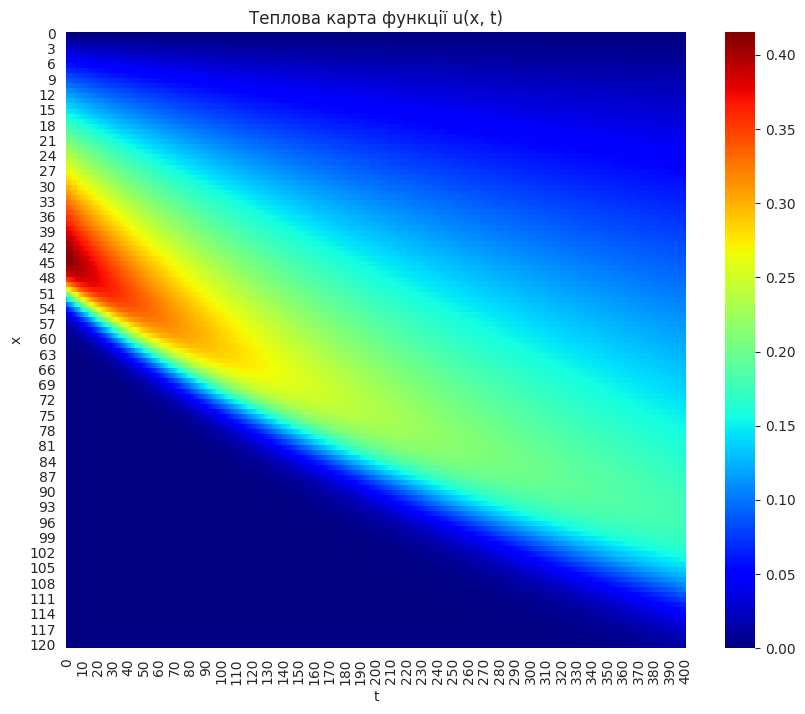

In [9]:
sns.set_style("white")
plt.figure(figsize=(10,8))
sns.heatmap(U_val, cmap='jet')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Теплова карта функції u(x, t)')
plt.show()


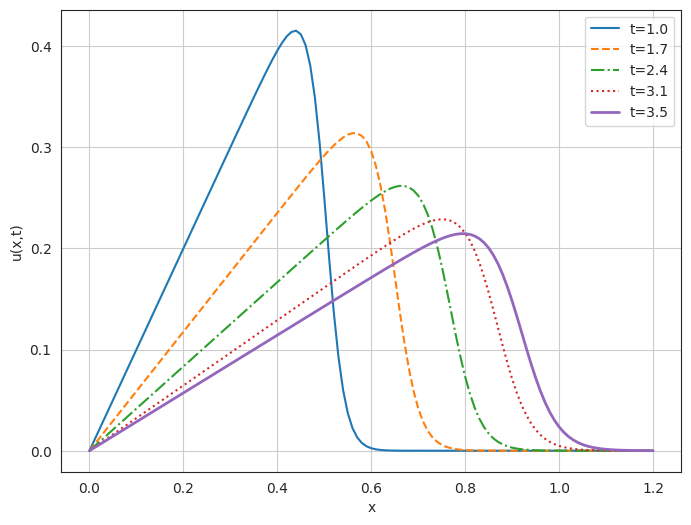

In [10]:
# Побудова графіку
plt.figure(figsize=(8, 6))    # Розміри графіку (ширина, висота) в дюймах

plt.plot(x_val, U_val[:,0], label='t=1.0', linestyle='-')
plt.plot(x_val, U_val[:,70], label='t=1.7', linestyle='--')
plt.plot(x_val, U_val[:,140], label='t=2.4', linestyle='-.')
plt.plot(x_val, U_val[:,210], label='t=3.1', linestyle=':')
plt.plot(x_val, U_val[:,250], label='t=3.5', linestyle='-', linewidth=2)

# Додавання заголовку, підписів вісей та легенди
# plt.title('Графік декількох кривих')
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.legend()   # Виведення легенди з назвами кривих

# Показати графік
plt.grid(True)   # Включити сітку
plt.show()


#Розв'язок засобами PINN

In [11]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.net = torch.nn.Sequential(
            nn.Linear(2,32),
            nn.Tanh(),
            nn.Linear(32,32),
            # nn.Tanh(),
            # nn.Linear(20,20),

            nn.Tanh(),
            nn.Linear(32,1)
        )

    def forward(self, x):
        out = self.net(x)
        return out

In [12]:
'''
x_test = torch.arange(-1,1+0.1, 0.1)
#print(x_test)
t_test = torch.arange(0,1+0.1, 0.1)
#print(t_test)

X = torch.stack(torch.meshgrid(x_test,t_test)).reshape(2,-1).T
#print(X)

bc1_test = torch.stack(torch.meshgrid(x_test[-1],t_test)).reshape(2,-1).T
#print(bc1_test)
#print(torch.meshgrid(x_test,t_test))

y_train_test = torch.tensor([1,2,3,4])
print(y_train_test)
y_train_test = y_train_test.unsqueeze(1)
print(y_train_test)
'''

'\nx_test = torch.arange(-1,1+0.1, 0.1)\n#print(x_test)\nt_test = torch.arange(0,1+0.1, 0.1)\n#print(t_test)\n\nX = torch.stack(torch.meshgrid(x_test,t_test)).reshape(2,-1).T\n#print(X)\n\nbc1_test = torch.stack(torch.meshgrid(x_test[-1],t_test)).reshape(2,-1).T\n#print(bc1_test)\n#print(torch.meshgrid(x_test,t_test))\n\ny_train_test = torch.tensor([1,2,3,4])\nprint(y_train_test)\ny_train_test = y_train_test.unsqueeze(1)\nprint(y_train_test)\n'

In [13]:
# h = 0.01
# k = 0.01
# nu = 0.5

# x = torch.arange(0,8+h, h)
# t = torch.arange(0,5+k, k)

# X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
# bc2 = torch.stack(torch.meshgrid(x[-1],t)).reshape(2,-1).T

# # bc2[:,1]+10e-5
# # X[:,1]
# # bc2.size()
# # X.size()
# y_bc2 = (bc2[:,0]/(bc2[:,1]+10e-6))*1/(1+torch.sqrt((bc2[:,1]+10e-6)*nu/0.125)*torch.exp(bc2[:,0]**2/4*nu*(bc2[:,1]+10e-6)))
# y_bc2

torch.pi

3.141592653589793

In [14]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.model = NN().to(device)

        self.x_max = 1.2
        self.t_max = 5

        # comp. domain
        self.h = 0.001
        self.k = 0.01
        self.nu = 0.005
        self.epoch = 2000

        x = torch.arange(0, self.x_max + self.h, self.h)
        t = torch.arange(1, self.t_max + self.k, self.k)


        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
        # print('self.X ', self.X.shape)
        # breakpoint()



        # train data
        bc1 = torch.stack(torch.meshgrid(x[0],t)).reshape(2,-1).T
        bc2 = torch.stack(torch.meshgrid(x[-1],t)).reshape(2,-1).T
        ic  = torch.stack(torch.meshgrid(x,t[0])).reshape(2,-1).T
        # ic2  = torch.stack(torch.meshgrid(x,t[-1])).reshape(2,-1).T
        # print('bc1, ', bc1.shape)
        # print('bc2, ', bc2.shape)
        # print('ic, ', ic.shape)
        # breakpoint()

        self.X_train = torch.cat([bc1, bc2, ic])

        # print('self.X_train ', self.X_train.shape)
        # breakpoint()

        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))

        y_ic  = ic[:,0] / (1 + torch.exp((ic[:,0]**2 - 0.25)/(4*self.nu)))

        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])


        self.y_train = self.y_train.unsqueeze(1)



        self.X = self.X.to(device)
        self.y_train = self.y_train.to(device)
        self.X_train = self.X_train.to(device)
        self.X.requires_grad = True

        # optimizer setting
        self.adam =  torch.optim.Adam(self.model.parameters())
        #Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter = 2000,
            max_eval = 2000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )

        self.criterion = torch.nn.MSELoss()
        self.iter = 1

    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        y_pred = self.model(self.X_train)

        # print('y_pred ', y_pred.shape)
        # print('self.y_train.shape ', self.y_train.shape)
        # breakpoint()


        loss_data = self.criterion(y_pred - self.y_train, torch.zeros_like(self.y_train))

        u = self.model(self.X)

        du_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0]

        #print(du_dX)
        #print("xxxxxxxxxxxxxxxxxxxxxxxxx")
        #print(du_dX[0])

        du_dt = du_dX[:,1]
        du_dx = du_dX[:,0]

        # print('du_dx ', du_dx.shape)
        # print('du_dt ', du_dt.shape)
        # breakpoint()


        du_dXX = torch.autograd.grad(
            du_dX,
            self.X,
            grad_outputs = torch.ones_like(du_dX),
            create_graph = True,
            retain_graph = True
        )[0]

        du_dxx = du_dXX[:,0]

        loss_pde = self.criterion(du_dt + u.squeeze()*du_dx - self.nu * du_dxx, torch.zeros_like(du_dxx))

        loss = loss_pde + loss_data
        loss.backward()

        if self.iter % 100 == 0:
            print(self.iter, loss.item())
            print(loss_pde.item())
            print(loss_data.item())
        self.iter = self.iter+1

        return loss

    def train(self):
        self.model.train()
        for i in range(self.epoch):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()

In [15]:
# training
net = Net()
net.train()

/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


100 0.010995064862072468
0.0008121987339109182
0.010182865895330906
200 0.01031780056655407
0.0007860925979912281
0.009531707502901554
300 0.009263676591217518
0.0006040773005224764
0.008659599348902702
400 0.007596458774060011
0.00027127275825478137
0.007325185928493738
500 0.00495341420173645
0.0003362235438544303
0.004617190454155207
600 0.0023172940127551556
0.0005318741896189749
0.0017854197649285197
700 0.0015848205657675862
0.0005127796903252602
0.001072040875442326
800 0.0012217335170134902
0.0004809852980542928
0.0007407482480630279
900 0.001033219275996089
0.0004539929796010256
0.0005792262963950634
1000 0.0008966305758804083
0.000415521179093048
0.0004811093967873603
1100 0.0007693554507568479
0.000369189860066399
0.0004001655906904489
1200 0.0006715566851198673
0.00033738964702934027
0.0003341670671943575
1300 0.0005920827970840037
0.00030825831345282495
0.00028382448363117874
1400 0.0005234017735347152
0.00027912631048820913
0.0002442754339426756
1500 0.0004711807414423674

In [16]:
net.model.eval()

NN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [17]:
h = 0.01
k = 0.01

x = torch.arange(0, net.x_max+h,h)
t = torch.arange(1, net.t_max+k,k)

X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X = X.to(net.X.device)

In [18]:
X

tensor([[0.0000, 1.0000],
        [0.0000, 1.0100],
        [0.0000, 1.0200],
        ...,
        [1.2000, 4.9800],
        [1.2000, 4.9900],
        [1.2000, 5.0000]], device='cuda:0')

In [19]:
X.shape

torch.Size([48521, 2])

In [20]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X)
    y_pred = y_pred.reshape(len(x),len(t)).cpu().numpy()

In [21]:
y_pred.shape

(121, 401)

In [22]:
y_pred

array([[ 7.87526369e-05, -1.80155039e-05, -1.06200576e-04, ...,
         2.78457999e-04,  2.82362103e-04,  2.86415219e-04],
       [ 1.01647824e-02,  9.97109711e-03,  9.78721678e-03, ...,
         2.16244161e-03,  2.16214359e-03,  2.16196477e-03],
       [ 2.02382654e-02,  1.99480504e-02,  1.96689516e-02, ...,
         4.05119359e-03,  4.04657423e-03,  4.04225290e-03],
       ...,
       [-2.75850296e-04, -2.55286694e-04, -2.36153603e-04, ...,
         1.47791058e-02,  1.52670741e-02,  1.57652497e-02],
       [-3.41311097e-04, -3.19287181e-04, -2.98827887e-04, ...,
         1.04305446e-02,  1.08201504e-02,  1.12188309e-02],
       [-4.10407782e-04, -3.86938453e-04, -3.64989042e-04, ...,
         6.92766905e-03,  7.23217428e-03,  7.54471123e-03]], dtype=float32)

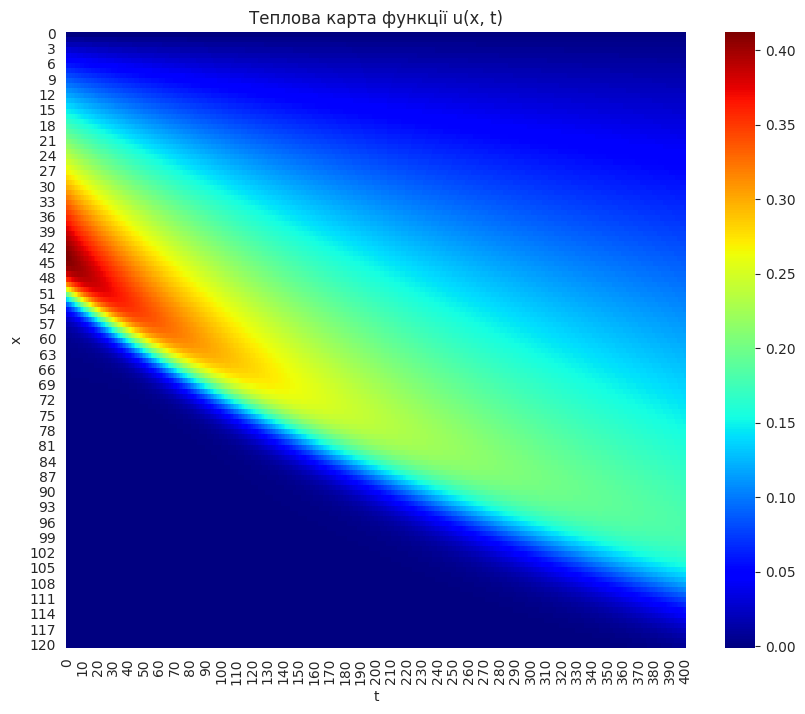

In [23]:
sns.set_style("white")
plt.figure(figsize=(10,8))
sns.heatmap(y_pred, cmap='jet')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Теплова карта функції u(x, t)')
plt.show()



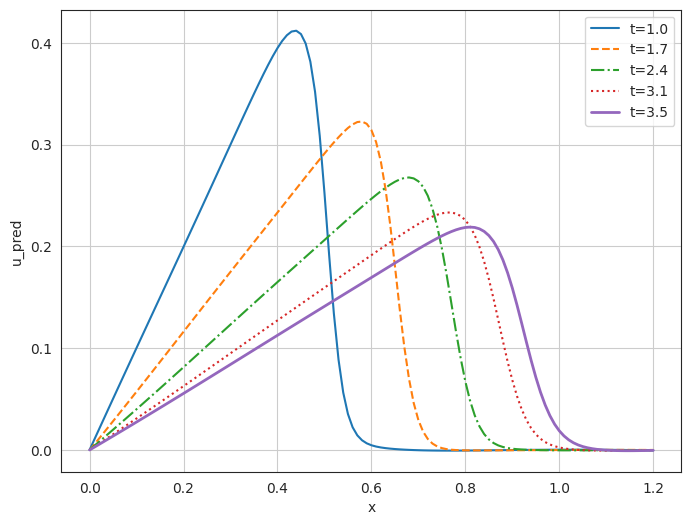

In [24]:
# Побудова графіку
plt.figure(figsize=(8, 6))    # Розміри графіку (ширина, висота) в дюймах

plt.plot(x, y_pred[:,0], label='t=1.0', linestyle='-')
plt.plot(x, y_pred[:,70], label='t=1.7', linestyle='--')
plt.plot(x, y_pred[:,140], label='t=2.4', linestyle='-.')
plt.plot(x, y_pred[:,210], label='t=3.1', linestyle=':')
plt.plot(x, y_pred[:,250], label='t=3.5', linestyle='-', linewidth=2)

# Додавання заголовку, підписів вісей та легенди
# plt.title('Графік декількох кривих')
plt.xlabel('x')
plt.ylabel('u_pred')
plt.legend()   # Виведення легенди з назвами кривих

# Показати графік
plt.grid(True)   # Включити сітку
plt.show()



Порівняння з іншими результатами

In [25]:
def relative_error(exact_values, approx_values):
    # Перевірка на відповідність розмірності списків
    if len(exact_values) != len(approx_values):
        raise ValueError("Списки точних і наближених значень повинні мати однакову довжину.")

    # Ініціалізуємо список для збереження відносних похибок
    relative_errors = []

    # Обчислюємо відносну похибку для кожного спостереження
    for exact, approx in zip(exact_values, approx_values):
        if exact != 0:
            # Обчислення відносної похибки
            error = abs((approx - exact) / exact)
        else:
            # Якщо точне значення дорівнює нулю, встановлюємо похибку як нескінченість
            error = float('inf') if approx != 0 else 0.0

        # Додаємо обчислену відносну похибку до списку
        relative_errors.append(error)

    return relative_errors


In [26]:
import pandas as pd
data17 = {
    'x': [0.2, 0.4, 0.6, 0.8],
    'Exact': [0.1176452, 0.2351677, 0.2959097, 0.0006465],
    'PINN': [y_pred[20,70],y_pred[40,70], y_pred[60,70], y_pred[80,70]]
}

df17 = pd.DataFrame(data17)
df17['Relative Error'] = relative_error(df17['Exact'], df17['PINN'])
df17

,x,Exact,PINN,Relative Error
0,0.2,0.117645,0.116186,0.012404
1,0.4,0.235168,0.233341,0.007766
2,0.6,0.295910,0.314313,0.062193
3,0.8,0.000647,-0.000395,1.611697


In [27]:
import pandas as pd
data25 = {
    'x': [0.2, 0.4, 0.6, 0.8],
    'Exact': [0.0799990, 0.1599769, 0.2381207, 0.1020957],
    'PINN': [y_pred[20,150],y_pred[40,150], y_pred[60,150], y_pred[80,150]]
}

df25 = pd.DataFrame(data25)
df25['Relative Error'] = relative_error(df25['Exact'], df25['PINN'])
df25

,x,Exact,PINN,Relative Error
0,0.2,0.079999,0.078005,0.024923
1,0.4,0.159977,0.158305,0.010452
2,0.6,0.238121,0.237193,0.003894
3,0.8,0.102096,0.102440,0.003369


In [28]:
import pandas as pd
data30 = {
    'x': [0.2, 0.4, 0.6, 0.8],
    'Exact': [0.0666658, 0.1333209, 0.1994805, 0.2088359],
    'PINN': [y_pred[20,200],y_pred[40,200], y_pred[60,200], y_pred[80,200]]
}

df30 = pd.DataFrame(data30)
df30['Relative Error'] = relative_error(df30['Exact'], df30['PINN'])
df30

,x,Exact,PINN,Relative Error
0,0.2,0.066666,0.064833,0.027490
1,0.4,0.133321,0.131639,0.012618
2,0.6,0.199481,0.197848,0.008182
3,0.8,0.208836,0.221529,0.060780


In [29]:
import pandas as pd
data35 = {
    'x': [0.2, 0.4, 0.6, 0.8],
    'Exact': [0.0571422, 0.1142779, 0.1712242, 0.2145869],
    'PINN': [y_pred[20,250],y_pred[40,250], y_pred[60,250], y_pred[80,250]]
}

df35 = pd.DataFrame(data35)
df35['Relative Error'] = relative_error(df35['Exact'], df35['PINN'])
df35

,x,Exact,PINN,Relative Error
0,0.2,0.057142,0.055535,0.028127
1,0.4,0.114278,0.112653,0.014215
2,0.6,0.171224,0.169451,0.010353
3,0.8,0.214587,0.218648,0.018926


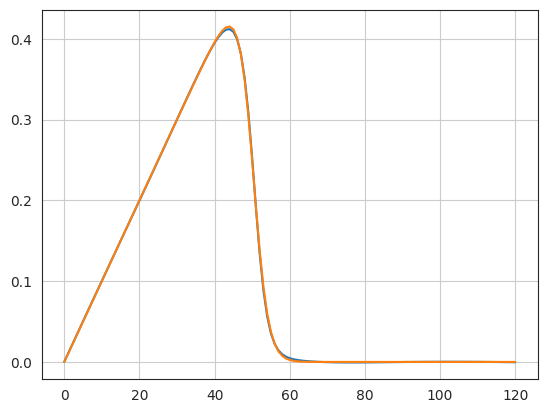

In [30]:
plt.plot(y_pred[:,0])
plt.plot(U_val[:,0])
plt.grid(True)
plt.show()

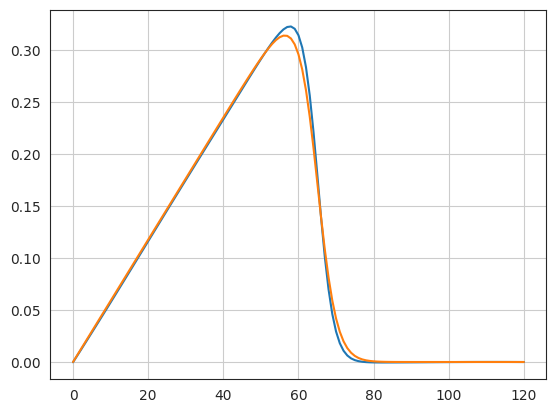

In [31]:
plt.plot(y_pred[:,70])
plt.plot(U_val[:,70])
plt.grid(True)
plt.show()

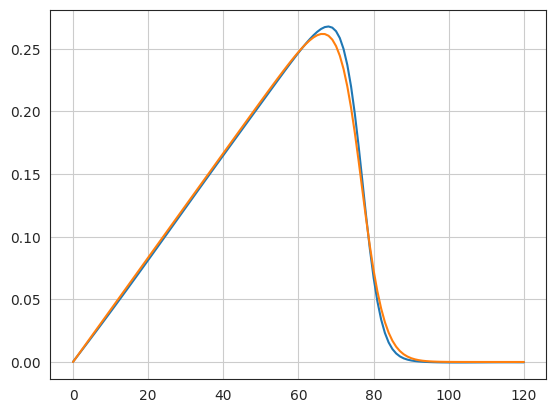

In [32]:
plt.plot(y_pred[:,140])
plt.plot(U_val[:,140])
plt.grid(True)
plt.show()

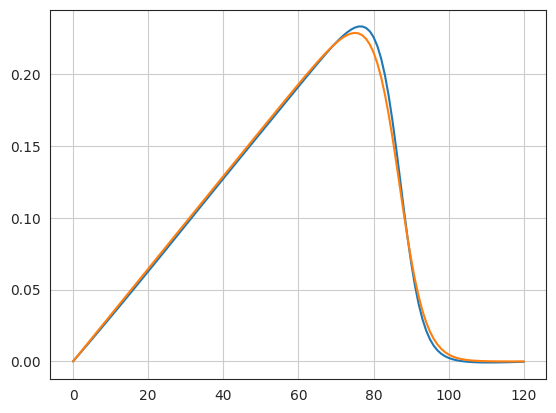

In [33]:
plt.plot(y_pred[:,210])
plt.plot(U_val[:,210])
plt.grid(True)
plt.show()

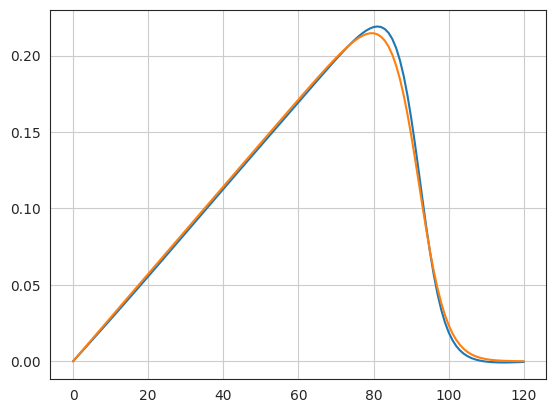

In [34]:
plt.plot(y_pred[:,250])
plt.plot(U_val[:,250])
plt.grid(True)
plt.show()

In [35]:
U_val.shape

(121, 401)

In [36]:
y_pred.shape

(121, 401)

In [37]:
from sklearn.metrics import r2_score

r2_score(U_val, y_pred)

0.9976337462444289

#Обернена задача

In [38]:
class Net_inv:
    def __init__(self, uf):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.viscosity_coeff = 0.005
        lambda_value = 2.0
        print("the real value =",self.viscosity_coeff, "     Our I-PINNs value=", lambda_value)
        self.lambda_value = torch.tensor([lambda_value], requires_grad=True).float().to(device)

        self.lambda_value = nn.Parameter(self.lambda_value)

        self.model = NN().to(device)

        self.model.register_parameter('lambda_value', self.lambda_value)

        self.x_max = 1.2
        self.t_max = 5
        # comp. domain
        self.h = 0.01
        self.k = 0.01
        self.epoch = 6000

        self.lambda_hist = []
        x = torch.arange(0, self.x_max + self.h, self.h)
        t = torch.arange(1, self.t_max + self.k, self.k)




        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
        # print('self.X ', self.X.shape)
        # breakpoint()

        print(self.X)

        # train data

        self.X_train = self.X

        self.y_train = torch.tensor(uf)

        self.y_train = self.y_train.view(-1)
        self.y_train = self.y_train.unsqueeze(1)

        print(self.y_train)

        # breakpoint()

        self.X = self.X.to(device)
        self.y_train = self.y_train.to(device)
        self.X_train = self.X_train.to(device)
        self.X.requires_grad = True

        # optimizer setting
        self.adam =  torch.optim.Adam(self.model.parameters())
        #Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter = 8000,
            max_eval = 8000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )

        self.criterion = torch.nn.MSELoss()
        self.iter = 1

    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        y_pred = self.model(self.X_train)

        # print('y_pred ', y_pred.shape)
        # print('self.y_train.shape ', self.y_train.shape)
        # breakpoint()


        loss_data = self.criterion(y_pred - self.y_train, torch.zeros_like(self.y_train))

        u = self.model(self.X)

        du_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0]

        #print(du_dX)
        #print("xxxxxxxxxxxxxxxxxxxxxxxxx")
        #print(du_dX[0])

        du_dt = du_dX[:,1]
        du_dx = du_dX[:,0]

        # print('du_dx ', du_dx.shape)
        # print('du_dt ', du_dt.shape)
        # breakpoint()


        du_dXX = torch.autograd.grad(
            du_dX,
            self.X,
            grad_outputs = torch.ones_like(du_dX),
            create_graph = True,
            retain_graph = True
        )[0]

        du_dxx = du_dXX[:,0]

        lambda_pde  = self.lambda_value

        loss_pde = self.criterion(du_dt + u.squeeze()*du_dx - lambda_pde * du_dxx, torch.zeros_like(du_dxx))

        loss = loss_pde + loss_data
        loss.backward()

        self.lambda_hist.append(self.lambda_value.item())
        if self.iter % 100 == 0:
            print("iteration number =",self.iter, " loss value =", loss.item(), "real mu=",self.viscosity_coeff,"IPINN lambda=", self.lambda_value.item())
        self.iter = self.iter+1

        return loss

    def train(self):
        self.model.train()
        for i in range(self.epoch):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()

In [39]:
net_inv = Net_inv(y_pred)
net_inv.train()
net_inv.model.eval()

the real value = 0.005      Our I-PINNs value= 2.0
tensor([[0.0000, 1.0000],
        [0.0000, 1.0100],
        [0.0000, 1.0200],
        ...,
        [1.2000, 4.9800],
        [1.2000, 4.9900],
        [1.2000, 5.0000]])
tensor([[ 7.8753e-05],
        [-1.8016e-05],
        [-1.0620e-04],
        ...,
        [ 6.9277e-03],
        [ 7.2322e-03],
        [ 7.5447e-03]])
iteration number = 100  loss value = 0.007818955928087234 real mu= 0.005 IPINN lambda= 1.960832118988037
iteration number = 200  loss value = 0.007522682659327984 real mu= 0.005 IPINN lambda= 1.9585628509521484
iteration number = 300  loss value = 0.007344226818531752 real mu= 0.005 IPINN lambda= 1.9551206827163696
iteration number = 400  loss value = 0.007197622209787369 real mu= 0.005 IPINN lambda= 1.9490466117858887
iteration number = 500  loss value = 0.0070641543716192245 real mu= 0.005 IPINN lambda= 1.941202998161316
iteration number = 600  loss value = 0.006946458946913481 real mu= 0.005 IPINN lambda= 1.931871891

NN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [40]:
h = 0.01
k = 0.01

x = torch.arange(0, net.x_max+h,h)
t = torch.arange(1, net.t_max+k,k)

X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X = X.to(net.X.device)

model = net_inv.model
model.eval()
with torch.no_grad():
    y_pred_inv = model(X)
    y_pred_inv = y_pred_inv.reshape(len(x),len(t)).cpu().numpy()

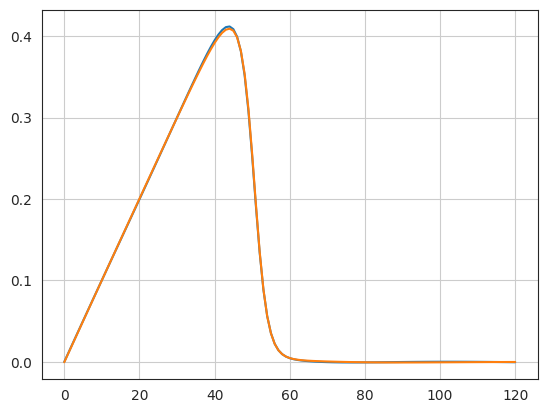

In [41]:
plt.plot(y_pred[:,0])
plt.plot(y_pred_inv[:,0])

plt.grid(True)
plt.show()

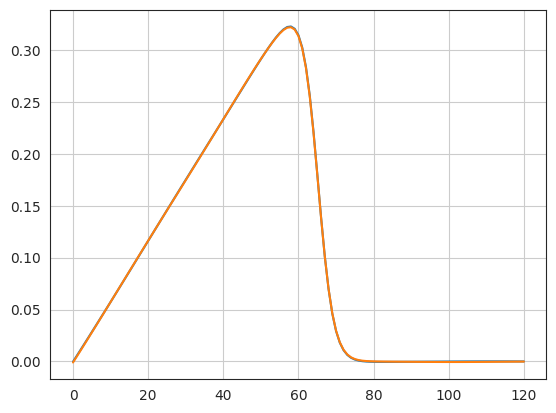

In [42]:
plt.plot(y_pred[:,70])
plt.plot(y_pred_inv[:,70])

plt.grid(True)
plt.show()

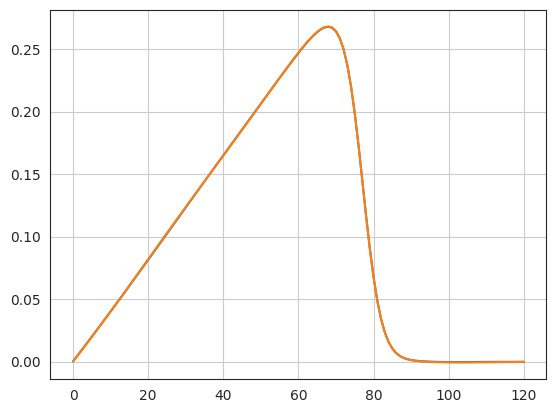

In [43]:
plt.plot(y_pred[:,140])
plt.plot(y_pred_inv[:,140])

plt.grid(True)
plt.show()

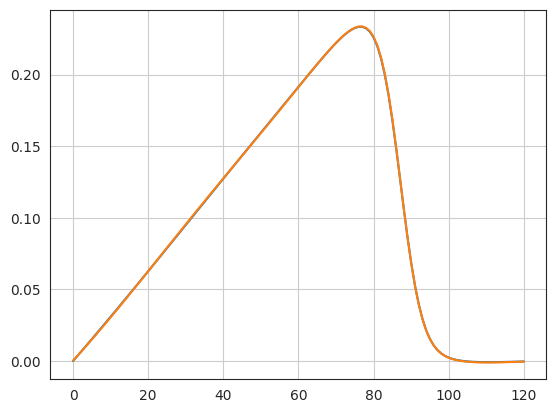

In [44]:
plt.plot(y_pred[:,210])
plt.plot(y_pred_inv[:,210])

plt.grid(True)
plt.show()

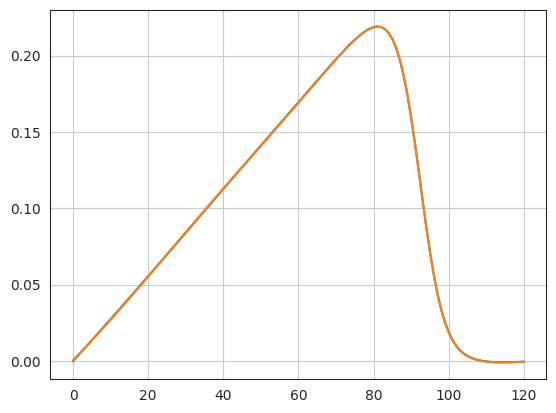

In [45]:
plt.plot(y_pred[:,250])
plt.plot(y_pred_inv[:,250])

plt.grid(True)
plt.show()

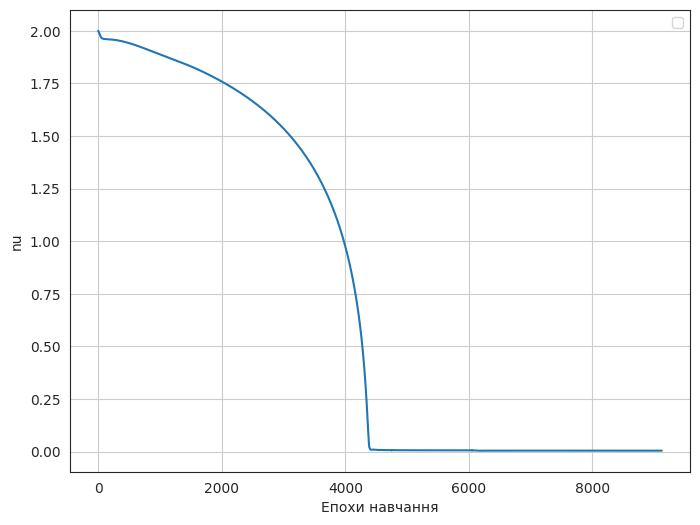

In [46]:
# Побудова графіку
plt.figure(figsize=(8, 6))    # Розміри графіку (ширина, висота) в дюймах

plt.plot(net_inv.lambda_hist)

# Додавання заголовку, підписів вісей та легенди
# plt.title('Графік декількох кривих')
plt.xlabel('Eпохи навчання')
plt.ylabel('nu')
plt.legend()   # Виведення легенди з назвами кривих

# Показати графік
plt.grid(True)   # Включити сітку
plt.show()


In [47]:
np.abs(net.nu - net_inv.lambda_hist[-1])/net.nu*100

0.46772174537182065